In [2]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
 
ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)
 
drive.mount(ROOT)           # we mount the google drive at /content/drive
%cd "/content/drive/My Drive/Deep Unfolded NMF"
%pwd

/content/drive
Mounted at /content/drive
/content/drive/My Drive/Deep Unfolded NMF


'/content/drive/My Drive/Deep Unfolded NMF'

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz

from scipy.io.wavfile import read, write
from scipy import signal
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler

from numpy import linalg as LA
from numpy.linalg import inv
from helpers2 import Reconstruct, Viz_Y,SMR,get_mixed_signal,SDR,butter_lowpass_filter, nmf
import seaborn as sns
import warnings
import math
from tqdm import tqdm

import torch
from torch import Tensor, transpose,abs, zeros, maximum, matmul, eye
from torch.optim import SGD
from torch.nn import MSELoss,ReLU


np.random.seed(7)

warnings.simplefilter('ignore')

In [4]:
# Best 1-15 min

start = 1 * 60 * 44100
end = 20 * 60 * 44100 

samplerate_s, data_speech = read("../PFE/DATA/Conversation.wav")
speech=data_speech[start:end,0]
length=speech.shape[0]/samplerate_s
print('Shape of the speech {} ... Length : {:.2f}s ... Sample rate : {}'.format(speech.shape[0],length,samplerate_s))

start = 1 * 60 * 44100
end = 5 * 60 * 44100 
samplerate_m, data_music = read("../PFE/DATA/Bigmusic2.wav")
music=data_music[start:end,0]
length=music.shape[0]/samplerate_m
print('Shape of the music {} ... Length : {:.2f}s ... Sample rate : {}'.format(music.shape[0],length,samplerate_m))


Shape of the speech 50274000 ... Length : 1140.00s ... Sample rate : 44100
Shape of the music 10584000 ... Length : 240.00s ... Sample rate : 44100


In [5]:
fs = 16000

rate = samplerate_s / fs


start = 1 * 60 * 44100
end = 20 * 60 * 44100


speech_t=data_speech[start : end, 0]
music_t = data_music[start : end, 0]


speech_t = signal.resample(speech_t,int(speech_t.shape[0]/rate))
music_t = signal.resample(music_t,int(music_t.shape[0]/rate))
samplerate=int(samplerate_m/rate)
length=music_t.shape[0]/samplerate

print('Shape of the test {} ... Length : {:.2f}s ... Sample rate : {}'.format(music_t.shape[0],length,samplerate))

speech = signal.resample(speech,int(speech.shape[0]/rate))
music = signal.resample(music,int(music.shape[0]/rate))


print('Downsampled rate = {}'.format(samplerate))

speech = butter_lowpass_filter(speech,5000,fs)
music = butter_lowpass_filter(music,5000,fs)

music_t = butter_lowpass_filter(music_t,5000,fs)
speech_t = butter_lowpass_filter(speech_t,5000,fs)

Shape of the test 18240000 ... Length : 1140.00s ... Sample rate : 16000
Downsampled rate = 16000


## 1.Training STFT :


In [6]:
WINDOW = 'hamming'
WINDOW_SIZE=480
OVERLAP = 0.8 * WINDOW_SIZE
NFFT=512

f,t,Y= signal.stft(speech,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs_s=np.abs(Y)
f,t,Y= signal.stft(music,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs_m=np.abs(Y)






SMR_db = 0



mix,speech_mix,music_mix=get_mixed_signal(speech_t,music_t,SMR_db)


f,t,Ymix= signal.stft(mix,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs_mix=np.abs(Ymix)

Yabs_mix[Yabs_mix==0]=0.00001



SMR = 0.00


## 2.Test STFT :

In [42]:
fs = 16000

rate = samplerate_s / fs


start = 15 * 60 * 44100
step = int(0.05 * 60 * 44100)

test_s = np.array([])
test_m = np.array([])

for i in range(1):

  test_s = np.hstack([test_s,data_speech[start+i*step:start+(i+1)*step,0]])
  test_m = np.hstack([test_m,data_music[start+i*step:start+(i+1)*step,0]])


test_s = signal.resample(test_s,int(test_s.shape[0]/rate))
test_m = signal.resample(test_m,int(test_m.shape[0]/rate))
samplerate=int(samplerate_m/rate)
length=music_t.shape[0]/samplerate


test_s = butter_lowpass_filter(test_s,5000,fs)
test_m = butter_lowpass_filter(test_m,5000,fs)


################################################################################
SMR_db = 0
test,speech_test,music_test=get_mixed_signal(test_s,test_m,SMR_db)


f,t,Ytest= signal.stft(test,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs_test=np.abs(Ytest)

f,t,Ytest_true= signal.stft(speech_test,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs_true=np.abs(Ytest_true)

Yabs_true[Yabs_true==0]=0.00001
Yabs_test[Yabs_test==0]=0.00001
write("results/MixX.wav", samplerate, test.astype(np.int16))


SMR = -0.00


# 3.Train First NMF on Clean Speech :

In [ ]:
def softmax(x):

  e_x = np.exp(x)
  return e_x / e_x.sum(axis=0)

In [ ]:
Nc = 8 #8
Nm = 8

model = NMF(n_components=Nc, init='random',alpha=0.2,beta_loss='frobenius',solver="mu",max_iter=100, random_state=7)
model.fit(np.transpose(Yabs_s))
Dc = np.transpose(model.components_)
#Dc=softmax(Dc)
scaler = MinMaxScaler()
Dc = scaler.fit_transform(Dc)


# 4.Train NMF on Noisy Speech :

In [ ]:
D,H = nmf(Yabs_mix,Dc,Nm, lamb=0.2, maxit=100)

scaler = MinMaxScaler()
D=scaler.fit_transform(D)

  0%|          | 0/100 [00:00<?, ?it/s]

Shape of Dc (257, 8) Shape of Dn (257, 8)
Dnorm shape (257, 16) and X shape (257, 190001) and H shape (16, 190001)


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


In [ ]:
np.save('Dictionary.npy',D)

# 5.Test NMF (Classic NMF with mu) :

In [9]:
D = np.load('Dictionary.npy')

Nc = 8 #8
Nm = 8

In [10]:
model_test = NMF(n_components=Nc+Nm, init='random',alpha=0.2,beta_loss='frobenius',solver="mu",max_iter=100, random_state=7)
model_test.fit(np.transpose(Yabs_test))
    
model_test.components_= np.transpose(D)
G_test=np.transpose(model_test.transform(np.transpose(Yabs_test)))

In [11]:
Sources,Masks=Reconstruct(B=D,G=G_test,Ns=Nc,Nm=Nm,Yabs=Ytest,p=0.5)

print('Reconstruction Step .... Done')
speech_est = Sources[0]
music_est = Sources[1]

_, speech_est =  signal.istft(speech_est,
                    samplerate,
                    window = WINDOW,
                    nperseg=WINDOW_SIZE,
                    noverlap=OVERLAP,
                    nfft = NFFT)

_, music_est =  signal.istft(music_est,
                    samplerate,
                    window = WINDOW,
                    nperseg=WINDOW_SIZE,
                    noverlap=OVERLAP,
                    nfft = NFFT)

sdr_speech = SDR(s_est=speech_est[:test_s.shape[0]],s=test_s)
sdr_music = SDR(s_est=music_est[:test_m.shape[0]], s=test_m)

print(f'Speech SDR = {sdr_speech}')
print(f'Music SDR = {sdr_music}')

Reconstruction Step .... Done
Speech SDR = 2.9617157134299084
Music SDR = 2.6736880182942118


In [ ]:
write("./results/SpeechX.wav", samplerate, speech_est.astype(np.int16))
write("./results/MusicX.wav", samplerate, music_est.astype(np.int16))


# 6.Warm Start ISTA :

In [12]:
def WarmISTA(X, W, alpha, h0, K, lambd,a):

  """
  X : Shape (F,T)
  W : Shape (F,r)

  """
  b = lambd/alpha
  np.random.seed(7)
  H = np.random.rand(W.shape[1],X.shape[1])
  H[:,0] = h0.ravel()
  for t in tqdm(np.arange(3,X.shape[1])):
    H[:,t] = a[0]*H[:,t-1]+a[1]*H[:,t-2]+a[2]*H[:,t-3]

    for k in np.arange(0,K):

      z = (np.identity(W.shape[1])-(1/alpha)*np.transpose(W)@W)@H[:,t] + (1/alpha)*np.transpose(W)@X[:,t]
      H[:,t] = np.maximum(np.abs(z)-b, np.zeros(z.shape[0]))

  return H

In [21]:
h0 = np.random.rand(D.shape[1],1)
alpha = 100
alphas = [0.4, 0.3, 0.3]
#alphas = [1, 0, 0]

Htest=WarmISTA(Yabs_test, D, alpha=alpha, h0=h0, K=3, lambd=0.2, a=alphas)
scaler = MinMaxScaler()
Htest=scaler.fit_transform(Htest)

100%|██████████| 998/998 [00:00<00:00, 6192.24it/s]


In [22]:
Sources,Masks=Reconstruct(B=D,G=Htest,Ns=Nc,Nm=Nm,Yabs=Ytest,p=0.5)

print('Reconstruction Step .... Done')
speech_est = Sources[0]
music_est = Sources[1]

_, speech_est =  signal.istft(speech_est,
                    samplerate,
                    window = WINDOW,
                    nperseg=WINDOW_SIZE,
                    noverlap=OVERLAP,
                    nfft = NFFT)

_, music_est =  signal.istft(music_est,
                    samplerate,
                    window = WINDOW,
                    nperseg=WINDOW_SIZE,
                    noverlap=OVERLAP,
                    nfft = NFFT)

sdr_speech = SDR(s_est=speech_est[:test_s.shape[0]],s=test_s)
sdr_music = SDR(s_est=music_est[:test_m.shape[0]], s=test_m)

print(f'Speech SDR = {sdr_speech}')
print(f'Music SDR = {sdr_music}')

Reconstruction Step .... Done
Speech SDR = 2.8027804756892944
Music SDR = 2.7047455791315405


# 7.Unfolded Warm Start ISTA (Loop Version) Doesnt work:


In [ ]:
def WarmISTA(X, W, alpha, h0, K, lambd):

  """
  X : Shape (F,T)
  W : Shape (F,r)

  """
  b = []
  H = []
  z= []

  I = eye(W[0].shape[1], dtype=torch.float64)

  for k in range(K):
    H.append(torch.tensor(np.random.rand(W[0].shape[1],X.shape[1])))
    b.append(Tensor([lambd/alpha[k].item()]))
    z.append(torch.tensor(np.zeros((W[0].shape[1],1))))

  H[0][:,0] = h0.clone().ravel()


  for t in tqdm(np.arange(1,X.shape[1])):

    H[0][:,t] = H[K-1][:,t-1]

    for k in np.arange(0,K):

      z[k] = matmul(I-(1/alpha[k])*matmul(W[k].clone().t(),W[k]),H[k][:,t]) + (1/alpha[k])*matmul(W[k].clone().t(),X[:,t])
      H[k][:,t] = maximum(abs(z[k])-b[k], zeros(z[k].shape[0]))

  return H

In [ ]:
EPOCHS = 10

for e in range(EPOCHS):


      H = WarmISTA(X,W_L,alpha_L,h0_L,K=2,lambd=0.2)
      print(f'Shape of H = {H[0].shape}')
      loss = loss(X,W_L[K-1],H[K-1],Y,Ns=Nc)
      optimizer.zero_grad()

      loss.backward()
      optimizer.step()

      print('epoch {} ... Loss = {:.2f}'.format(e,loss))



# 8.Unfolded Warm Start ISTA (Cell version) 

In [ ]:
D = np.load('Dictionary.npy') #Pretrained dictionary

X = Tensor(Yabs_test).float() #input tensor
Y = Tensor(Yabs_true).float() # output tensor (clean speech)
F = D.shape[0]
r = D.shape[1]
T = X.shape[1]
K = 3

a=8 # initialization of alphas.



"""
Initializing the list of K weights using the pretrained dictionary of the NMF D = [Ds Dn].
Initializing K alphas with the value 8.
"""
W_L = []
alpha_L = []

for k in range(K):

  W_L.append(Tensor(D).float())
  alpha_L.append(a)

alpha_L = Tensor(alpha_L).float()
alpha_L.requires_grad = True



"""
Initializing h0 with random values
"""
h0_L = Tensor(np.random.rand(r,1)).float()
h0_L.requires_grad=True


## Set require grad true
for k in range(K):

  W_L[k].requires_grad = True

  if ((W_L[k].requires_grad==False) | (alpha_L[k].requires_grad==False)):

    print(" For value k = {} ... gradient is off")




"""
Create a list of Gains H for each layer k.
"""
H=[]
H.append(torch.tensor(np.random.rand(D.shape[1],X.shape[1])).float())
H.append(torch.tensor(np.random.rand(D.shape[1],X.shape[1])).float())
H.append(torch.tensor(np.random.rand(D.shape[1],X.shape[1])).float())

In [ ]:
"""
Parameters list of the optimizer.
"""
params = W_L+[alpha_L]+[h0_L]
optimizer = SGD(params,lr=0.1)

In [27]:
def unfoldcell(X_t, H_t, W, alpha, lambd):
    """
    Cell that represents one layer (k) of unfolded ISTA returns the gain at time stamp t and layer k that will be used as H_t of the next layer.
    X_t : one input timestamp
    H_t : gain timestamp t. If k=0 the input should be H[K-1][:,t-1] else if k>0 the output of this cell will be the input of the next cell.
    W : W[k] weights of layer k.
    alpha : scalar tensor alpha[k] of layer k
    lambd : sparsity.
    """
    I = eye(W.shape[1], dtype=torch.float32)
    b = lambd/alpha.clone().item()

    h_tk = ReLU()(matmul(I-(1/alpha)*matmul(W.clone().t(),W),H_t) + (1/alpha)*matmul(W.clone().t(),X_t)-b)

    return h_tk


def Criteria(X, W, H, Y, Ns ,l):

  M = matmul(W[:,:Ns],H[:Ns])/(matmul(W[:,:Ns],H[:Ns]) + matmul(W[:,Ns:],H[Ns:]))
  
  loss = torch.norm(Y-M*X)
  #+ l*torch.minimum(W,Tensor([0])).min().item()**2

  return loss

In [140]:
"""
Comments in this cell are errors that we must check.
"""

#H[0][:,0]=h0_L.clone().ravel()
K=3
L=0.2
EPOCHS = 50
epoch_loss=[]

for e in range(EPOCHS):
  loss_e = 0
  for t in np.arange(1,X.shape[1]):

    h_t0=unfoldcell(X[:,t], H[K-1][:,t-1],W_L[0],alpha_L[0],L)
    h_t1=unfoldcell(X[:,t], h_t0,W_L[1],alpha_L[1],L)
    h_t2=unfoldcell(X[:,t], h_t0,W_L[2],alpha_L[2],L)

    #H[0][:,t]=h_t0.ravel()
    #H[1][:,t]=h_t1.ravel()
    #H[2][:,t]=h_t2.ravel()

    loss = Criteria(X[:,t],W_L[K-1],H[K-1][:,t],Y[:,t],Ns=Nc,l=0.000001)
    optimizer.zero_grad()

    loss.backward(retain_graph=True)
    optimizer.step()

    loss_e += loss.item()
  print(f'Epoch {e} ... Loss = {loss_e}')
  epoch_loss.append(loss_e)

Epoch 0 ... Loss = 245372.0725631714
Epoch 1 ... Loss = 245334.47021484375
Epoch 2 ... Loss = 245297.46082305908
Epoch 3 ... Loss = 245261.01425170898
Epoch 4 ... Loss = 245225.10931015015
Epoch 5 ... Loss = 245189.71173477173
Epoch 6 ... Loss = 245154.79441070557
Epoch 7 ... Loss = 245120.3444595337
Epoch 8 ... Loss = 245086.32744979858
Epoch 9 ... Loss = 245052.7250099182
Epoch 10 ... Loss = 245019.52285385132
Epoch 11 ... Loss = 244986.68662261963
Epoch 12 ... Loss = 244954.20977783203
Epoch 13 ... Loss = 244922.06296157837
Epoch 14 ... Loss = 244890.24171066284
Epoch 15 ... Loss = 244858.70998382568
Epoch 16 ... Loss = 244827.46924972534
Epoch 17 ... Loss = 244796.49227142334
Epoch 18 ... Loss = 244765.77128219604
Epoch 19 ... Loss = 244735.27867889404
Epoch 20 ... Loss = 244705.01434707642
Epoch 21 ... Loss = 244674.96612548828
Epoch 22 ... Loss = 244645.11307907104
Epoch 23 ... Loss = 244615.45419692993
Epoch 24 ... Loss = 244585.97731018066
Epoch 25 ... Loss = 244556.69089126587

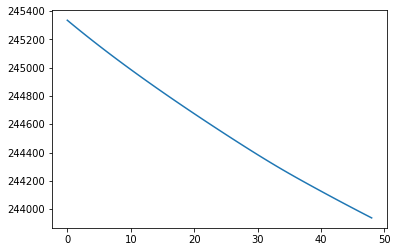

In [141]:
plt.plot(epoch_loss[1:])

In [142]:
"""
Get the numpy array of weights and gains of the last layer K 
"""
Weights = W_L[K-1].clone().detach().numpy()
gains = H[K-1].clone().detach().numpy()

scaler = MinMaxScaler()
Weights = scaler.fit_transform(Weights)
#gains = scaler.fit_transform(gains)

In [143]:
"""
Reconstruction step 
"""
Sources,Masks=Reconstruct(B=Weights,G=gains,Ns=Nc,Nm=Nm,Yabs=Ytest,p=0.5)

print('Reconstruction Step .... Done')
speech_est = Sources[0]
music_est = Sources[1]

_, speech_est =  signal.istft(speech_est,
                    samplerate,
                    window = WINDOW,
                    nperseg=WINDOW_SIZE,
                    noverlap=OVERLAP,
                    nfft = NFFT)

_, music_est =  signal.istft(music_est,
                    samplerate,
                    window = WINDOW,
                    nperseg=WINDOW_SIZE,
                    noverlap=OVERLAP,
                    nfft = NFFT)

sdr_speech = SDR(s_est=speech_est[:test_s.shape[0]],s=test_s)
sdr_music = SDR(s_est=music_est[:test_m.shape[0]], s=test_m)

print(f'Speech SDR = {sdr_speech}')
print(f'Music SDR = {sdr_music}')

Reconstruction Step .... Done
Speech SDR = 1.4307246422025264
Music SDR = 0.523367192873283


In [139]:
print(f'Min of Gains = {gains.min()} and Min of Weights = {Weights.min()}')
sns.distplot(Weights)
sns.distplot(gains)

Min of Gains = 2.2913254724699073e-05 and Min of Weights = 0.0
